# 훈련 모델 예측 시각화

In [1]:
# -*- coding: utf-8 -*-
import os,sys
sys.path.append(os.getcwd())
import torch
from model.unet_model import Ringed_Res_Unet # 사용 모델
from dataset.Defacto import test # defacto 데이터셋 한정 테스트 모듈
import torch.nn.functional as F
import torch.nn as nn
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# RRU-Net pre-trained
# rru_net = Ringed_Res_Unet().cuda()
# rru_net.load_state_dict(torch.load('../RRUNet/best_model.pth'))
rru_net = Ringed_Res_Unet().cuda()
rru_net.load_state_dict(torch.load('./result/logs/defactor/Ringed_Res_Unet/defactor-[val_dice]-0.4414-[train_loss]-0.3801.pkl'))

<All keys matched successfully>

torch.Size([1, 256, 256, 3])
torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


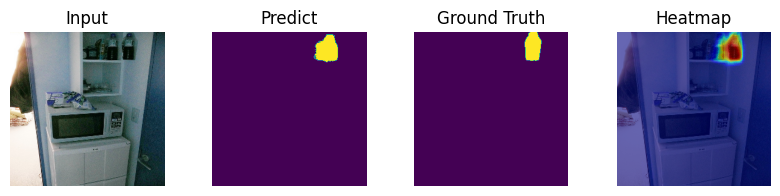

In [12]:
INDEX =  12# 13 #12 # 36
MODE = 'te1st' # 'any' : no purmute , no normalize / 'test' same 'train' condition

device = torch.device("cuda:0")
pred,img,mask = test(rru_net,device,INDEX,MODE)
if MODE in ['test','train']:
    img = img.permute(1,2,0)
    mask = mask.permute(1,2,0)
    
print(img.shape)

pred = F.sigmoid(pred)

pred_ = pred[0,:,:,:]
pred_ = pred_.permute(1,2,0)
pred_ = pred_.to('cpu').detach().numpy()

plt.figure(figsize=(10,2))
plt.subplot(141)
plt.imshow(img)
plt.title('Input')
plt.axis('off')
plt.subplot(142)
plt.imshow(pred_>0.5)#,cmap='jet',interpolation='nearest')
plt.title('Predict')
plt.axis('off')
plt.subplot(143)
plt.imshow(mask)
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(144)
plt.imshow(img)
plt.imshow(pred_.squeeze(-1) ,alpha=0.6,cmap='jet')
plt.title('Heatmap')
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


heatmap m n :  tensor(3.8212e-06) tensor(1.)
heatmap m n :  0 255 (256, 256)
heatmap m n :  0 255
im m n :  0.0 1.0


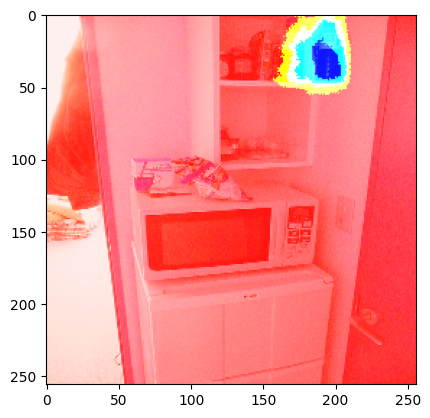

In [13]:
heatmap = torch.mean(pred.to('cpu'), dim=1).squeeze()
heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)
print('heatmap m n : ',heatmap.min(),heatmap.max())
heatmap = np.uint8(heatmap*255)
print('heatmap m n : ',heatmap.min(),heatmap.max(),heatmap.shape)
heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
print('heatmap m n : ',heatmap.min(),heatmap.max())
im = img.numpy()
im = (im-im.min())
im = (im/im.max())

print('im m n : ',im.min(),im.max())
heatmap_img = (heatmap*0.4 + im)
# cv.imshow('Jet',heatmap_img)
# cv.waitKey(0)
# cv.destroyAllWindows()
plt.imshow(heatmap_img)
plt.show()

In [6]:
from torchsummary import summary
summary(rru_net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         GroupNorm-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
         GroupNorm-5         [-1, 32, 256, 256]              64
   RRU_double_conv-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 32, 256, 256]              96
         GroupNorm-8         [-1, 32, 256, 256]              64
              ReLU-9         [-1, 32, 256, 256]               0
           Conv2d-10          [-1, 3, 256, 256]              96
           Conv2d-11         [-1, 32, 256, 256]             896
        GroupNorm-12         [-1, 32, 256, 256]              64
             ReLU-13         [-1, 32, 256, 256]               0
           Conv2d-14         [-1, 32, 2

In [7]:
print(rru_net)

Ringed_Res_Unet(
  (down): RRU_first_down(
    (conv): RRU_double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): GroupNorm(32, 32, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (4): GroupNorm(32, 32, eps=1e-05, affine=True)
      )
    )
    (relu): ReLU(inplace=True)
    (res_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): GroupNorm(32, 32, eps=1e-05, affine=True)
    )
    (res_conv_back): Sequential(
      (0): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (down1): RRU_down(
    (conv): RRU_double_conv(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (2): ReLU(inpla

In [8]:
print('# generator parameters:', 1.0 * sum(param.numel() for param in rru_net.parameters())/1000000)
params = list(rru_net.named_parameters())
for i in range(len(params)):
    (name, param) = params[i]
    print(name)
    print(param.shape)
    

# generator parameters: 4.097249
down.conv.conv.0.weight
torch.Size([32, 3, 3, 3])
down.conv.conv.0.bias
torch.Size([32])
down.conv.conv.1.weight
torch.Size([32])
down.conv.conv.1.bias
torch.Size([32])
down.conv.conv.3.weight
torch.Size([32, 32, 3, 3])
down.conv.conv.3.bias
torch.Size([32])
down.conv.conv.4.weight
torch.Size([32])
down.conv.conv.4.bias
torch.Size([32])
down.res_conv.0.weight
torch.Size([32, 3, 1, 1])
down.res_conv.1.weight
torch.Size([32])
down.res_conv.1.bias
torch.Size([32])
down.res_conv_back.0.weight
torch.Size([3, 32, 1, 1])
down1.conv.conv.0.weight
torch.Size([64, 32, 3, 3])
down1.conv.conv.0.bias
torch.Size([64])
down1.conv.conv.1.weight
torch.Size([64])
down1.conv.conv.1.bias
torch.Size([64])
down1.conv.conv.3.weight
torch.Size([64, 64, 3, 3])
down1.conv.conv.3.bias
torch.Size([64])
down1.conv.conv.4.weight
torch.Size([64])
down1.conv.conv.4.bias
torch.Size([64])
down1.res_conv.0.weight
torch.Size([64, 32, 1, 1])
down1.res_conv.1.weight
torch.Size([64])
down1.r